# Промежуточный проект

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(palette="Set2")

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [5]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

Как видно, датасет содержит 8523 записи и 12 фичей, из них 5 численных и 7 категориальных. У признаков Item_Weight и Outlet_Size есть пропуски. Таргет-переменная - это Item_Outlet_Sales.

Идентификатор объекта (признак Item_Identifier) не несет в себе особого смысла и на продажу продукта влиять не должен. Его можно удалить.

In [6]:
del data['Item_Identifier']

### Обработка пропусков

Заполним пропуски признака Item_Weight средним значением веса по категории продукта (признак Item_Type).

In [7]:
data['Item_Weight'] = data.groupby('Item_Type')['Item_Weight'].apply(lambda x: x.fillna(x.mean()))

Пропуски признака Outlet_Size заполним наиболее частым значением по признаку Outlet_Type, т.к. площадь магазина скорее всего зависит от того, является ли магазин продуктовым или супермаркетом.

In [8]:
data['Outlet_Size'] =  data.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0]))

### EDA

In [9]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857890,0.066132,140.992782,1997.831867,2181.288914
std,4.232804,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.867061,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Посмотрим на гистограммы категориальных признаков.

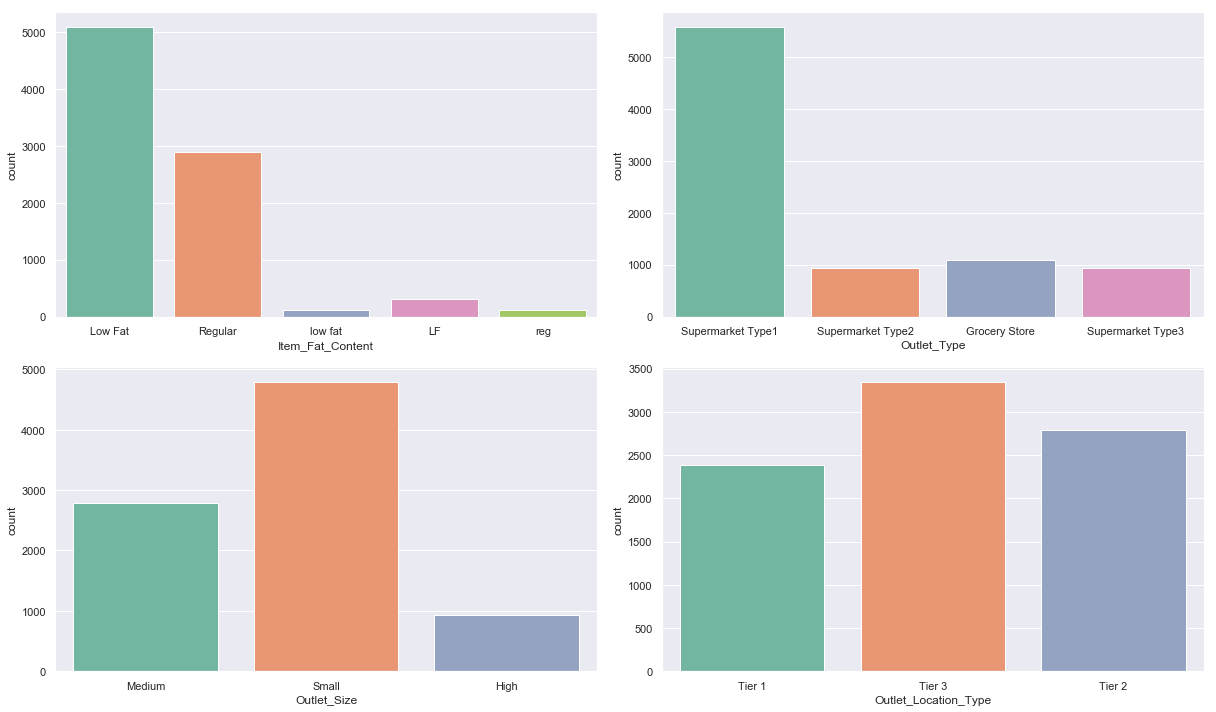

In [10]:
f, axes = plt.subplots(2, 2, figsize=(17, 10))
sns.countplot(x='Item_Fat_Content', data=data, ax=axes[0, 0])
sns.countplot(x='Outlet_Type', data=data, ax=axes[0, 1])
sns.countplot(x='Outlet_Size', data=data, ax=axes[1, 0])
sns.countplot(x='Outlet_Location_Type', data=data, ax=axes[1, 1])
f.tight_layout();

Как видно, признак Item_Fat_Content содержит дубликаты. Значения продуктов с низким жиром Low Fat, low fat и LF - одно и то же (что, кстати говоря, преобладает), так же Regular и reg - одно и то же. <br>
В признаке Outlet_Type преобладает Supermarket Type 1. В признаке Outlet_Size - магазины среднего Medium и маленького Small размеров. В признаке Outlet_Location_Type значения распределены практически равномерно.

Исправим дубликаты в признаке Item_Fat_Content

In [12]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].map({'low fat' : 'Low Fat', 
                                                         'LF' : 'Low Fat',
                                                         'reg' : 'Regular'})

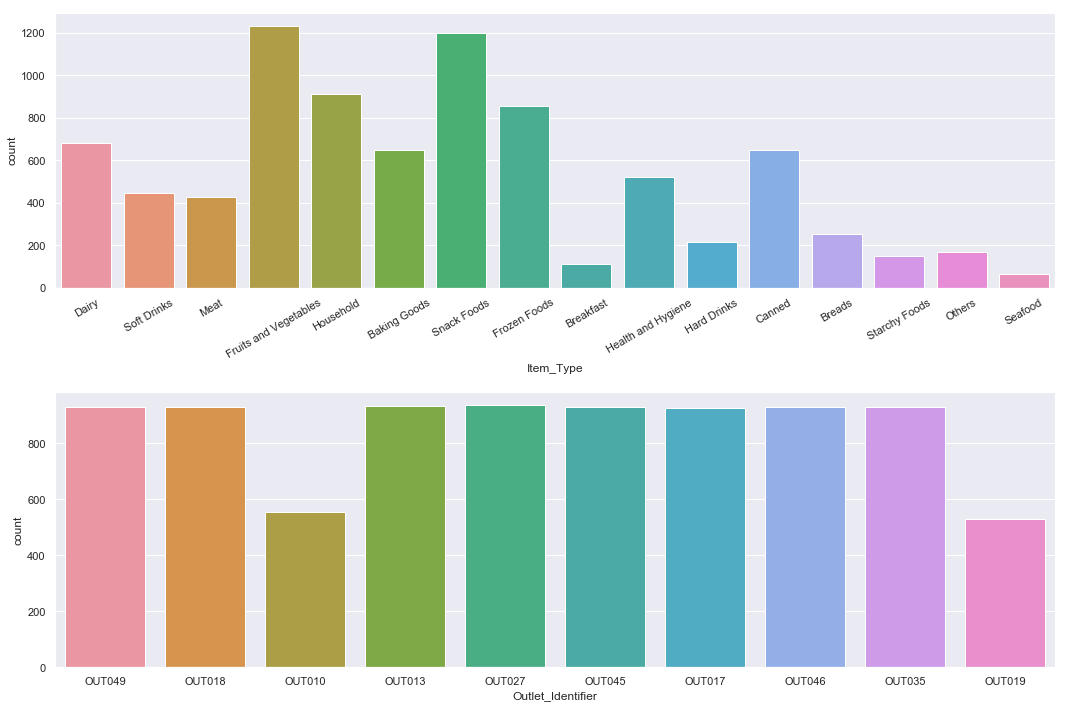

In [13]:
f, axes = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.countplot(x='Item_Type', data=data, ax=axes[0])
ax2 = sns.countplot(x='Outlet_Identifier', data=data, ax=axes[1])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
f.tight_layout();

Признак Item_Type содержит 16 типов продуктов, среди них больше всего молочки, фруктов и овощей, хозяйственных товаров, выпечки, снэков, замороженных продуктов и консервации. <br>
Исходя из признака Outlet_Identifier можно сделать вывод, что данные собраны по 10 магазинам, причем собраны равномерно, за исключением магазинов с идентификаторами OUT10 и OUT19.

Посмотрим на гистограммы численных признаков.

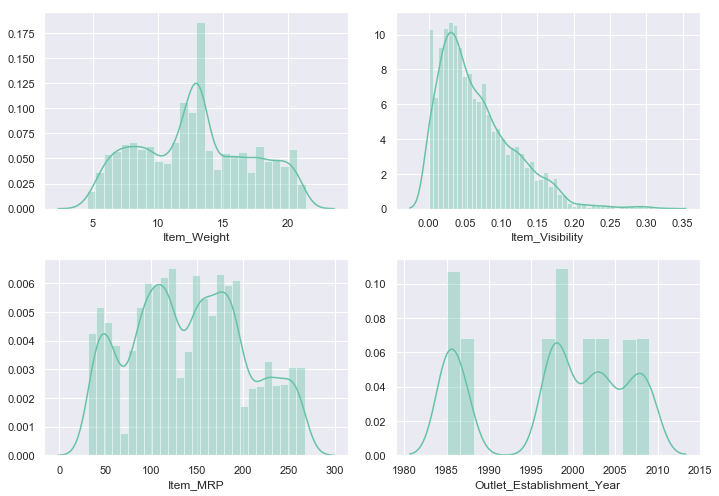

In [16]:
f, axes = plt.subplots(2, 2, figsize=(10, 7))
sns.distplot(data['Item_Weight'], ax=axes[0, 0])
sns.distplot(data['Item_Visibility'], ax=axes[0, 1])
sns.distplot(data['Item_MRP'], ax=axes[1, 0])
sns.distplot(data['Outlet_Establishment_Year'], ax=axes[1, 1])
f.tight_layout();

Среди признака Item_Weight больше всего продуктов со средним весом. У признака Item_Visibility логарифмическое распределение. 

Рассмотрим, как на значения тагрет-переменной Item_Outlet_Sales влияют категориальные переменные с помощью графиков box-plot.

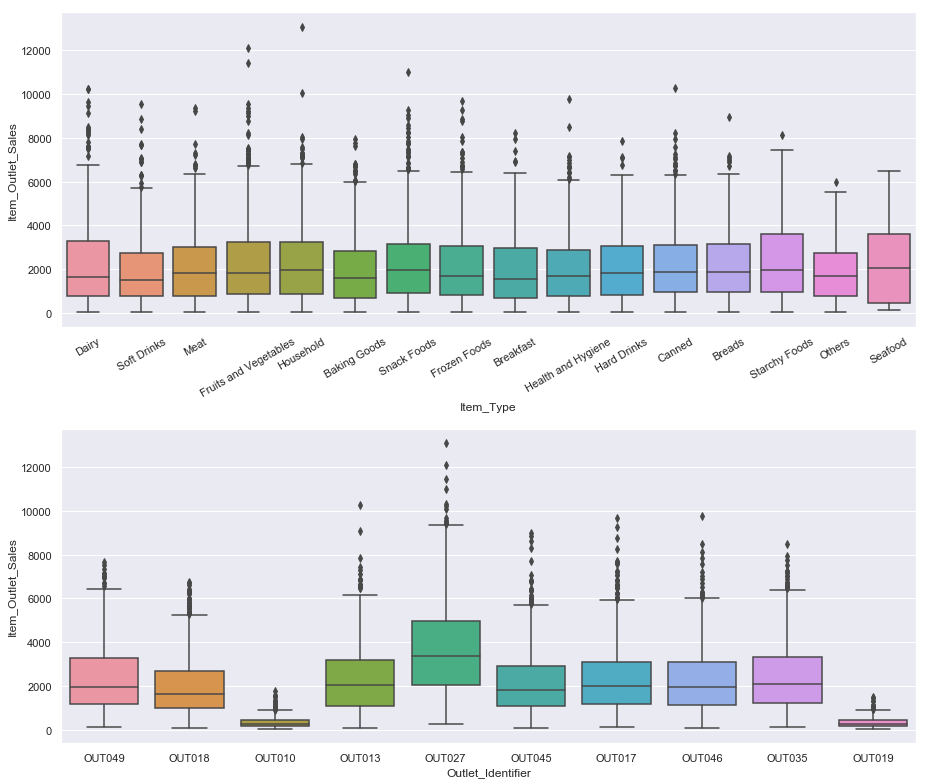

In [18]:
f, axes = plt.subplots(2, 1, figsize=(13, 11))
ax1 = sns.boxplot(y="Item_Outlet_Sales", x="Item_Type", data=data, ax=axes[0])
sns.boxplot(y="Item_Outlet_Sales", x="Outlet_Identifier", data=data, ax=axes[1])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
f.tight_layout();

Как видно, продажи для типов продуктов (Item_Type) распределены примерно одинаково. Для магазинов меньше всего продаж у OUT10 и OUT19, но у этих магазинов меньше всего записей. Больше всего продаж у магазина OUT27.

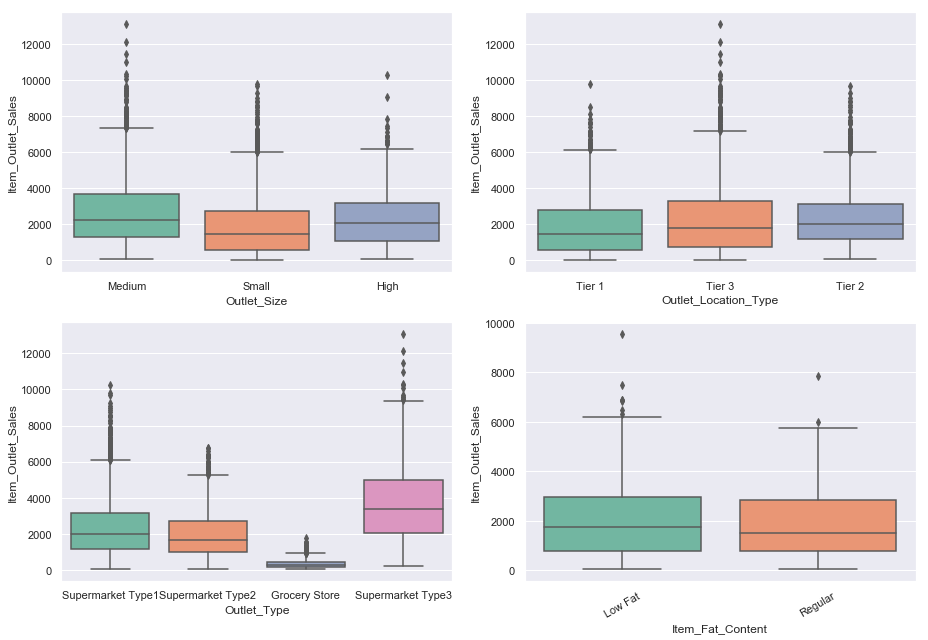

In [22]:
f, axes = plt.subplots(2, 2, figsize=(13, 9))
sns.boxplot(y="Item_Outlet_Sales", x="Outlet_Size", data=data, ax=axes[0,0])
sns.boxplot(y="Item_Outlet_Sales", x="Outlet_Location_Type", data=data, ax=axes[0, 1])
sns.boxplot(y="Item_Outlet_Sales", x="Outlet_Type", data=data, ax=axes[1, 0])
ax4 = sns.boxplot(y="Item_Outlet_Sales", x="Item_Fat_Content", data=data, ax=axes[1, 1])
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=30)
f.tight_layout();

Исходя из признака Outlet_Size, в среднем немного больше продаж в средних и больших магазинах, чем в маленьких. Для категорий признаков Outlet_Location_Type и Item_Fat_Content размер продаж распределен практически одинаково. <br>
По типам магазинов (Outlet_Type) больше всего продаж в магазинах типа Supermarket Type3, меньше всего в Grocery Store.

### Обработка категориальных признаков

Выделим все категорильные признаки и используем One Hot Encoding.

In [23]:
cat_feat = list(data.dtypes[data.dtypes == object].index)
dummy_data = pd.get_dummies(data[cat_feat])
data = pd.concat([data.drop(cat_feat, axis=1), dummy_data], axis=1)

data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,1999,3735.1380,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,2009,443.4228,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.6180,1999,2097.2700,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,1998,732.3800,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
4,8.93,0.000000,53.8614,1987,994.7052,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


### Нормализация

Для дальнейшей корректной работы нормализуем значения.

In [24]:
scaled_features = StandardScaler().fit_transform(data.values)
scaled_data = pd.DataFrame(scaled_features, index=data.index, columns=data.columns)

scaled_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,-0.840601,-0.970732,1.747454,0.139541,0.910601,-0.229939,-0.117977,-0.286855,-0.174193,-0.114346,...,-0.350395,1.432326,-1.134925,1.602840,-0.696678,-0.804732,-0.381529,0.726802,-0.349551,-0.351028
1,-1.639173,-0.908111,-1.489023,1.334103,-1.018440,-0.229939,-0.117977,-0.286855,-0.174193,-0.114346,...,-0.350395,1.432326,-1.134925,-0.623893,-0.696678,1.242650,-0.381529,-1.375891,2.860816,-0.351028
2,1.096763,-0.956917,0.010040,0.139541,-0.049238,-0.229939,-0.117977,-0.286855,-0.174193,-0.114346,...,-0.350395,1.432326,-1.134925,1.602840,-0.696678,-0.804732,-0.381529,0.726802,-0.349551,-0.351028
3,1.498411,-1.281758,0.660050,0.020085,-0.849103,-0.229939,-0.117977,-0.286855,-0.174193,-0.114346,...,-0.350395,-0.698165,0.881116,-0.623893,-0.696678,1.242650,2.621031,-1.375891,-0.349551,-0.351028
4,-0.928018,-1.281758,-1.399220,-1.293934,-0.695373,-0.229939,-0.117977,-0.286855,-0.174193,-0.114346,...,2.853918,-0.698165,-1.134925,-0.623893,-0.696678,1.242650,-0.381529,0.726802,-0.349551,-0.351028


### Корреляция

Посмотрим корреляцию признаков друг с другом и с таргет-переменной.

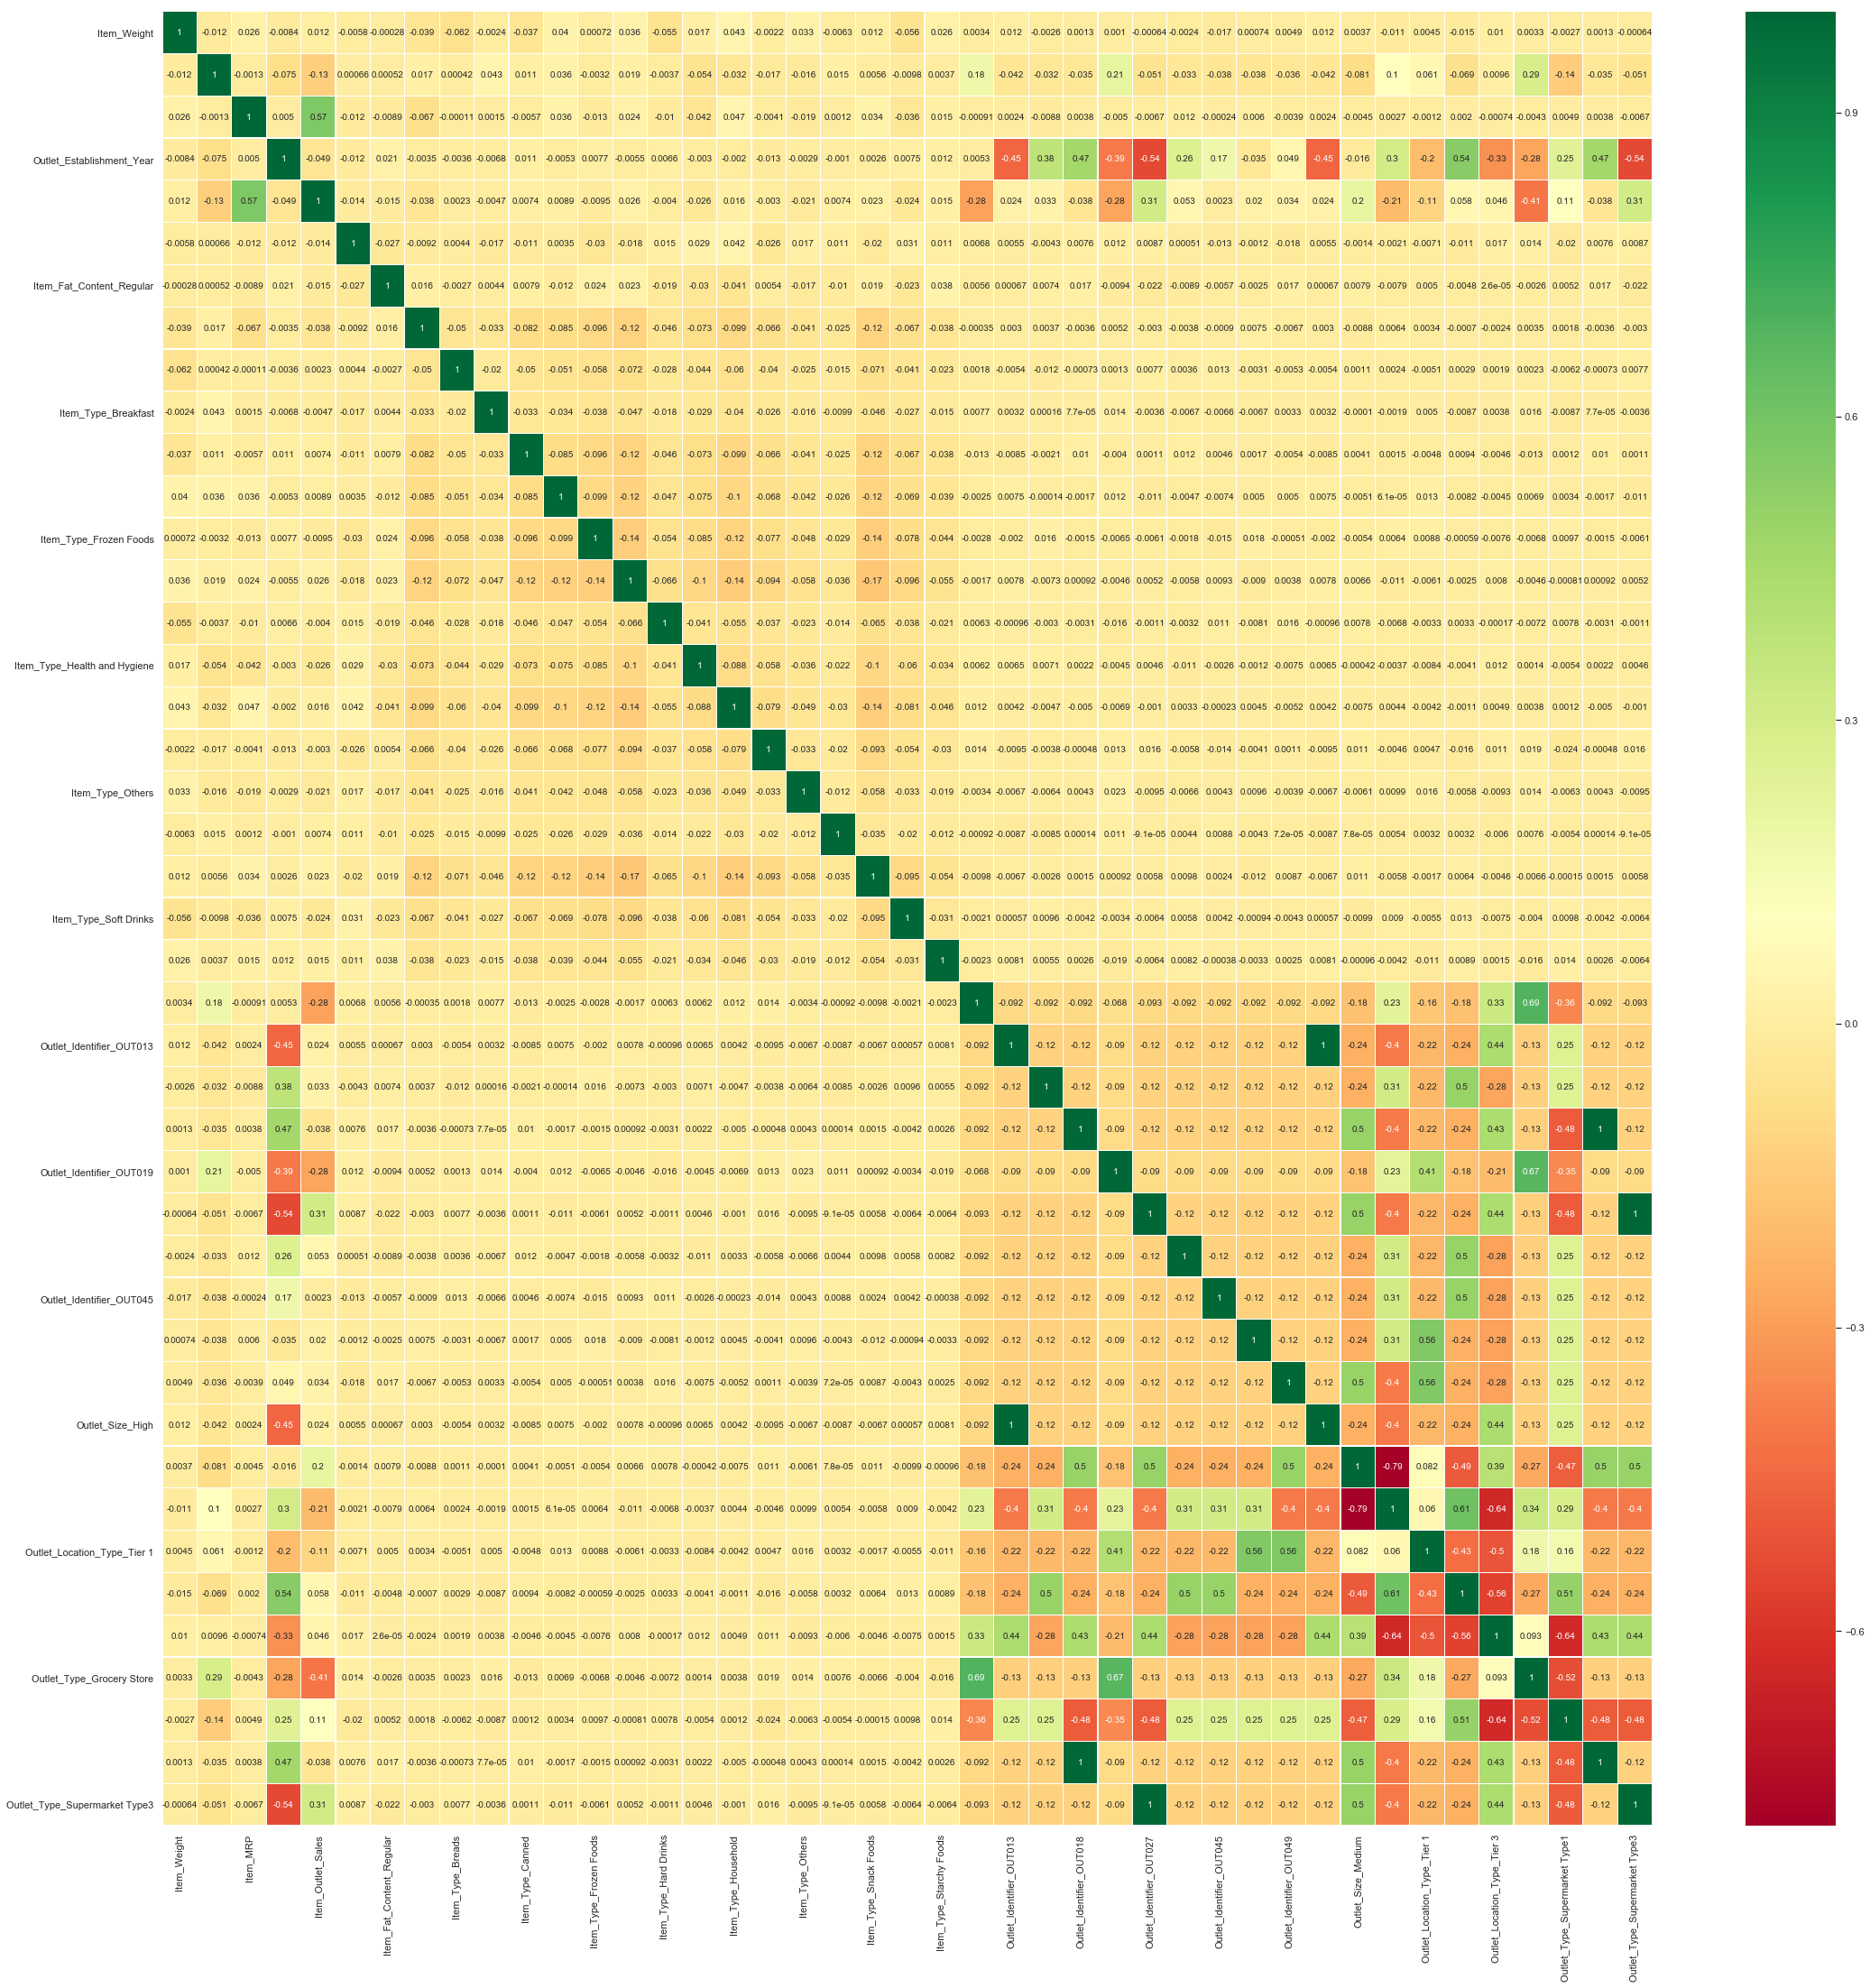

In [27]:
sns.heatmap(scaled_data.corr(), annot=True, cmap='RdYlGn', linewidths=0.2) 
fig = plt.gcf()
fig.set_size_inches(37,37)
plt.show()

Таргет-признак продаж продукта Item_Outlet_Sales коррелирует с максимальной ценой продажи продукта (Item_MRP) со значением 0.57 с продуктовым типом магазина (Outlet_Type_Grocery Store) со значением -0.41. С остальными признаками продажи коррелируют слабо, со значением корреляции меньше 0.40. <br>
Кроме того, стоит отметить, что есть признаки, между которыми корреляция свыше 0.7. Например, между признаками Outlet_Type_Supermarket Type3 и Outlet_Identifier_OUT27 значение корреляции 1.

### Обоснование метрики

Качество полученной модели будем измерять на основе среднеквадратической ошибки MSE, исходя из того, что это метрика регрессии (а у нас задача регрессии - прогнозирование продаж) и она дает представление о размере ошибки модели.

### Разбиение на трейн и тест выборки

In [28]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data.drop('Item_Outlet_Sales', axis=1),
                                                   scaled_data['Item_Outlet_Sales'],
                                                   test_size=0.3,
                                                   random_state=17)

In [29]:
X_train.shape, X_test.shape

((5966, 42), (2557, 42))

### Подбор параметров для линейной модели

В качестве линейной модели возьмем модель Ridge. С помощью GridSearchCV подберем наиболее оптимальные параметры. Варьировать будем параметр alpha, который отвечает за силу регуляризации. 

In [42]:
ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0]
}

In [43]:
ridge = Ridge(random_state=17)
grid_ridge = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.01, 0.1, 1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [55]:
print('Оптимальное значение параметров:', grid_ridge.best_params_)
print('Отрицательное значение MSE:', grid_ridge.best_score_)
print('Построенная модель:', grid_ridge.best_estimator_)

Оптимальное значение параметров: {'alpha': 30.0}
Отрицательное значение MSE: -0.4427489885507693
Построенная модель: Ridge(alpha=30.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)


### Подбор параметров для нелинейной модели

В качестве линейной модели возьмем модель RandomForestRegressor. С помощью GridSearchCV подберем наиболее оптимальные параметры. Варьировать будем параметры n_estimators, max_depth, min_samples_leaf и max_features.

In [59]:
forest_params = {
    'n_estimators': [10, 20, 30, 40, 50, 60],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [10, 13, 15, 18, 20, 25],
    'max_features': [20, 25, 30, 35, 40, 42]
}

In [60]:
forest = RandomForestRegressor(random_state=17)
grid_forest = GridSearchCV(forest, forest_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60], 'max_depth': [5, 7, 9, 11, 13, 15], 'min_samples_leaf': [10, 13, 15, 18, 20, 25], 'max_features': [20, 25, 30, 35, 40, 42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [61]:
print('Оптимальное значение параметров:', grid_forest.best_params_)
print('Отрицательное значение MSE:', grid_forest.best_score_)
print('Построенная модель:', grid_forest.best_estimator_)

Оптимальное значение параметров: {'max_depth': 7, 'max_features': 30, 'min_samples_leaf': 25, 'n_estimators': 60}
Отрицательное значение MSE: -0.3994798135247014
Построенная модель: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=25,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=None, oob_score=False, random_state=17,
           verbose=0, warm_start=False)


Пока что меньше значение MSE у Random Forest.

### Стекинг

Подберем оптимальные параметры для еще нескольких моделей с помощью GridSearch и проведем стекинг.

**SVR**

In [68]:
svr_params = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0]
}

In [69]:
svr = SVR()
grid_svr = GridSearchCV(svr, svr_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train, y_train)

/Users/karina/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [70]:
print('Оптимальное значение параметров:', grid_svr.best_params_)
print('Отрицательное значение MSE:', grid_svr.best_score_)
print('Построенная модель:', grid_svr.best_estimator_)

Оптимальное значение параметров: {'C': 1.0, 'epsilon': 0.1}
Отрицательное значение MSE: -0.4212119222585965
Построенная модель: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


**GradientBoostingRegressor**

In [113]:
gbr_params = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0],
    'n_estimators': [40, 50, 60, 70, 100, 110]
}

In [114]:
gbr = GradientBoostingRegressor(random_state=17)
grid_gbr = GridSearchCV(gbr, gbr_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gbr.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=17, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['ls', 'lad', 'huber', 'quantile'], 'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0], 'n_estimators': [40, 50, 60, 70, 100, 110]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [115]:
print('Оптимальное значение параметров:', grid_gbr.best_params_)
print('Отрицательное значение MSE:', grid_gbr.best_score_)
print('Построенная модель:', grid_gbr.best_estimator_)

Оптимальное значение параметров: {'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 40}
Отрицательное значение MSE: -0.4013124088275706
Построенная модель: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, n_iter_no_change=None, presort='auto',
             random_state=17, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [75]:
# функция для получения метапризнаков

def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [144]:
stack_cv = KFold(n_splits=10, random_state=20)

meta_train = []
meta_test = []
col_names = []

print('Ridge features...')
meta_tr, meta_te = get_meta_features(grid_ridge.best_estimator_, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rg_pred')

print('RandomForest features...')
meta_tr, meta_te = get_meta_features(grid_forest.best_estimator_, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('SupportVectorRegression features...')
meta_tr, meta_te = get_meta_features(grid_svr.best_estimator_, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('svr_pred')

print('GradientBoostingRegressor features...')
meta_tr, meta_te = get_meta_features(grid_gbr.best_estimator_, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('gbr_pred')

Ridge features...
RandomForest features...
SupportVectorRegression features...
GradientBoostingRegressor features...


In [117]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

Проведем стекинг мета-признаков, используя простую модель LineaeRegression со стандартными параметрами.

In [125]:
lr_meta = LinearRegression()
lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Оценка стекинга на отложенной выборке

In [126]:
scores_meta_test = cross_val_score(lr_meta, X_meta_test, y_test, cv=10, scoring='neg_mean_squared_error')

In [127]:
np.mean(scores_meta_test)

-0.3982926207592473

Посмотрим, насколько каждая модель повлияла на конечный результат.

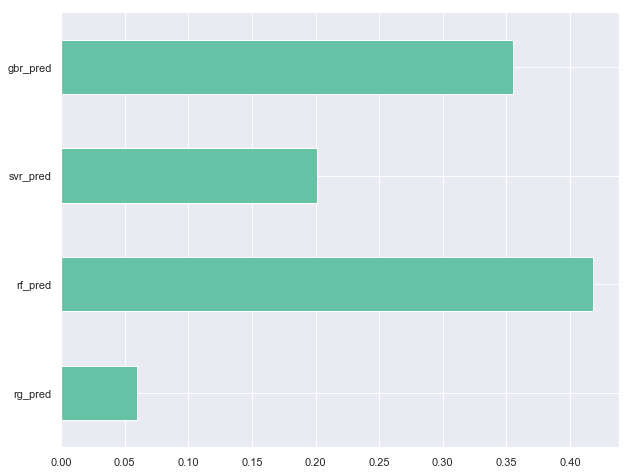

In [128]:
pd.Series(lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh');

###  Топ 3 признака больше всего влияющие на объемы продаж

Посмотрим, какие признаки отобрали две модели, которые внесли самый большой вклад, как исходя из графика выше: GradientBoostingRegressor и RandomForestRegressor.

**GradientBoostingRegressor**

In [145]:
fi_gbr = list(zip(grid_gbr.best_estimator_.feature_importances_, X_train.columns))

In [146]:
fi_gbr.sort(reverse=True)
fi_gbr[0:3]

[(0.5356180311695845, 'Item_MRP'),
 (0.3042271447265731, 'Outlet_Type_Grocery Store'),
 (0.06182149238410251, 'Outlet_Type_Supermarket Type3')]

**RandomForestRegressor**

In [147]:
fi_rf = list(zip(grid_forest.best_estimator_.feature_importances_, X_train.columns))

In [148]:
fi_rf.sort(reverse=True)
fi_rf[0:3]

[(0.5567015333694127, 'Item_MRP'),
 (0.27161000218575165, 'Outlet_Type_Grocery Store'),
 (0.05572200192259034, 'Outlet_Type_Supermarket Type3')]

Как видно, в обеих моделях топ 3 одинаковый. Больше всего влияет признак Item_MRP - максимальная цена продукта, что логично. На втором месте Outlet_Type_Grocery Store - продуктовый тип магазина. С этим признаком у продаж была отрицательная высокая корреляция. На третьем месте признак Outlet_Type_Supermarket Type3, который соответствует типу магазина - супермаркет. То есть, продаж в продуктовых магазинах меньше и больше в супермаркетах. 